In [33]:
import torch
import torchvision
import torchvision.transforms as transfroms
import matplotlib.pyplot as plt
import numpy as np

In [34]:
batch_size = 10
transfrom = transfroms.Compose([
    transfroms.ToTensor(),
    transfroms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

In [35]:
trainset = torchvision.datasets.CIFAR10(root="./data",train=True, download=True,  transform=transfrom)
trainloder = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [36]:
testset = torchvision.datasets.CIFAR10(root="./data",train=False, download=True,  transform=transfrom)
testloder = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [37]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [38]:
dataiter = iter(trainloder)
images, labels = dataiter.__next__()

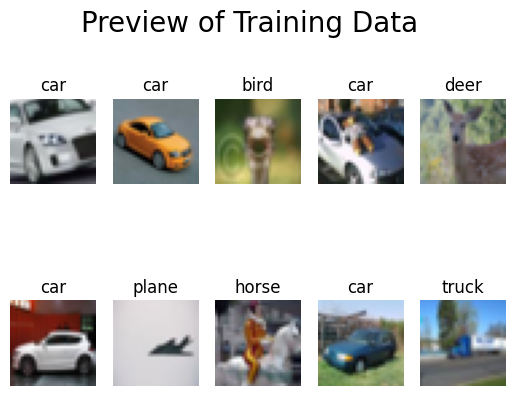

In [39]:
for i in range(batch_size):
    plt.subplot(2, int(batch_size/2), i+1)
    img = images[i]
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')
    plt.title(classes[labels[i]])
    
plt.suptitle("Preview of Training Data", size=20)
plt.show()

# Neural Network

In [40]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6, 5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5, 120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


# Training the model 

In [41]:
from tqdm import tqdm

epochs=10

for epoch in range(epochs):
    running_loss=0.0
    for i, data in enumerate(tqdm(trainloder, desc=f"epoch {epoch+1} of {epochs}", leave=True, ncols=80)):
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loos=criterion(outputs, labels)
        loos.backward()
        optimizer.step()

epoch 10 of 10: 100%|██████████████████████| 5000/5000 [00:11<00:00, 433.13it/s]


In [42]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

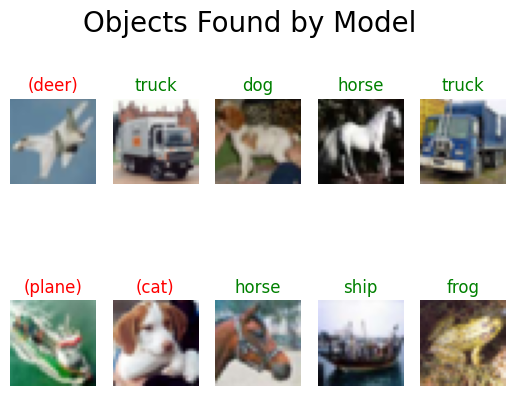

In [46]:
# Pick random photos from training set
if dataiter == None:
    dataiter = iter(testloder)
images, labels = dataiter.__next__()

# Load our model
net = Net()
net.load_state_dict(torch.load(PATH))

# Analyze images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.show()

In [47]:
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloder:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 80.6 %
Accuracy for class: car   is 75.4 %
Accuracy for class: bird  is 52.7 %
Accuracy for class: cat   is 38.1 %
Accuracy for class: deer  is 57.0 %
Accuracy for class: dog   is 48.6 %
Accuracy for class: frog  is 63.8 %
Accuracy for class: horse is 69.1 %
Accuracy for class: ship  is 70.5 %
Accuracy for class: truck is 69.8 %
